In [1]:
import os
import torch
import pickle
import seaborn as sns
import torch.nn as nn
from typing import Type
from torch import Tensor
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
"""
Builds ResNet18 from scratch using PyTorch.
This does not build generalized blocks for all ResNets, just for ResNet18.
Paper => Deep Residual Learning for Image Recognition.
Link => https://arxiv.org/pdf/1512.03385v1.pdf
"""
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return  out

In [3]:
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        # print('Dimensions of the last convolutional feature map: ', x.shape)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [4]:
if __name__ == '__main__':
    tensor = torch.rand([1, 3, 225, 224])
    model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=1000)
    print(model)
    
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

    output = model(tensor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = self.load_data()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, label = self.images[idx], self.labels[idx]

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return {'image': image, 'label': label}

    def load_data(self):
        images = []
        labels = []

        for class_label in os.listdir(self.root_dir):
            class_path = os.path.join(self.root_dir, class_label)

            # Skip 'images' directory
            if not os.path.isdir(class_path) or class_label == 'images':
                continue

            label = int(class_label)  # Convert class label to integer (0 or 1)
            
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                images.append(file_path)
                labels.append(label)

        return images, labels

# Directory containing subdirectories '0' and '1'
data_saved_dir = r'D:\Datasets\Classification\B'
dataset_code = 'B'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the desired size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert PIL Image to tensor
])

# Create custom datasets with transformations
train_dataset = CustomDataset(os.path.join(data_saved_dir, 'train'), transform)
val_dataset = CustomDataset(os.path.join(data_saved_dir, 'val'), transform)
test_dataset = CustomDataset(os.path.join(data_saved_dir, 'test'), transform)

# Assuming batch_size and other hyperparameters
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

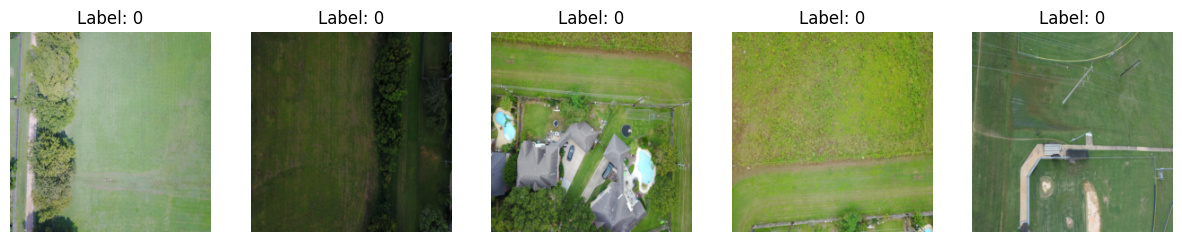

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        sample = dataset[i]
        image, label = sample['image'], sample['label']
        image = image.permute(1, 2, 0).numpy()  # Change tensor shape for plotting
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.show()

# Display samples from the training dataset
show_samples(train_dataset, num_samples=5)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=2)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50 

# Initialize history dictionary to store training and validation metrics
history = {'train_loss': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        images, labels = batch['image'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    average_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            outputs = model(images)
            _, predicted_val = torch.max(outputs.data, 1)

            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    accuracy_val = correct_val / total_val
    
    # Update history
    history['train_loss'].append(average_loss)
    history['train_accuracy'].append(accuracy_train)
    history['val_accuracy'].append(accuracy_val)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%; Validation Accuracy: {accuracy_val * 100:.2f}%')

Epoch [1/50], Training Loss: 0.7493, Training Accuracy: 67.88%; Validation Accuracy: 65.80%
Epoch [2/50], Training Loss: 0.4903, Training Accuracy: 74.76%; Validation Accuracy: 68.41%
Epoch [3/50], Training Loss: 0.4397, Training Accuracy: 79.74%; Validation Accuracy: 45.43%
Epoch [4/50], Training Loss: 0.4227, Training Accuracy: 80.86%; Validation Accuracy: 72.32%
Epoch [5/50], Training Loss: 0.4062, Training Accuracy: 81.65%; Validation Accuracy: 72.06%
Epoch [6/50], Training Loss: 0.3651, Training Accuracy: 85.00%; Validation Accuracy: 80.42%
Epoch [7/50], Training Loss: 0.3474, Training Accuracy: 85.73%; Validation Accuracy: 82.77%
Epoch [8/50], Training Loss: 0.3241, Training Accuracy: 86.40%; Validation Accuracy: 51.44%
Epoch [9/50], Training Loss: 0.3204, Training Accuracy: 86.29%; Validation Accuracy: 77.81%
Epoch [10/50], Training Loss: 0.3336, Training Accuracy: 86.35%; Validation Accuracy: 76.76%
Epoch [11/50], Training Loss: 0.3052, Training Accuracy: 87.86%; Validation Acc

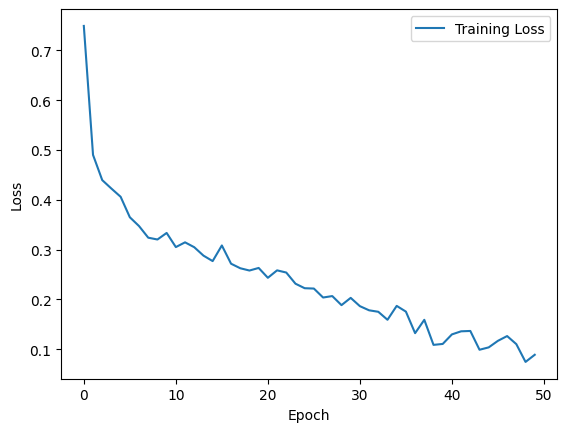

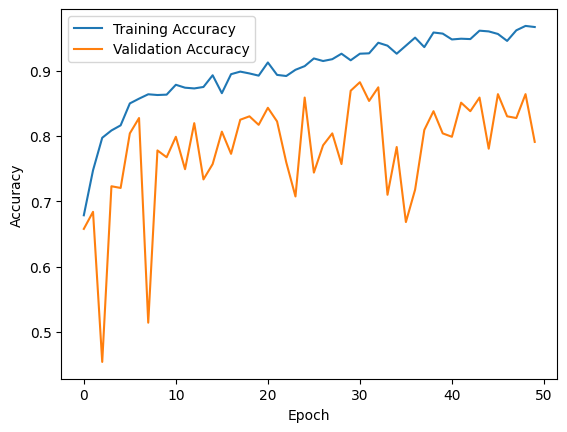

In [8]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


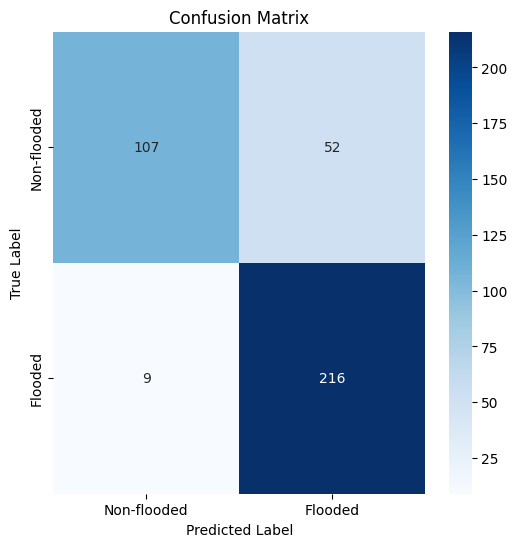

Classification Report:
               precision    recall  f1-score   support

 Non-flooded       0.92      0.67      0.78       159
     Flooded       0.81      0.96      0.88       225

    accuracy                           0.84       384
   macro avg       0.86      0.82      0.83       384
weighted avg       0.85      0.84      0.84       384



In [9]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['image'].to(device), batch['label'].to(device)  

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-flooded', 'Flooded'], yticklabels=['Non-flooded', 'Flooded'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(all_labels, all_preds, target_names=['Non-flooded', 'Flooded'])
print("Classification Report:\n", report)